In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset, ClassLabel
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import os
from torchvision.utils import save_image, make_grid
import time # To time training
import torchvision

In [13]:
# here, we are loading the datatset. Using trust_remote_code
try:
    dataset = load_dataset("cifar10", trust_remote_code=False)
except Exception as e:
     print(f"Failed to load dataset directly, trying with trust_remote_code=True: {e}")
     dataset = load_dataset("cifar10", trust_remote_code=True)


In [14]:
# Get the label feature information
label_feature = dataset['train'].features['label']
print("\nClass labels in CIFAR-10:")
print(label_feature.names)


Class labels in CIFAR-10:
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [15]:
# finding the integer labels for cats & dogs
try:
    cat_label = label_feature.str2int('cat')
    dog_label = label_feature.str2int('dog')
    target_labels = [cat_label, dog_label]
    target_class_names = {cat_label: 'cat', dog_label: 'dog'}
    print(f"\nTargeting classes: 'cat' (Label: {cat_label}) and 'dog' (Label: {dog_label})")
except ValueError as e:
    print(f"Error finding class names: {e}")
    print("Falling back to default CIFAR-10 labels: cat=3, dog=5")
    cat_label = 3
    dog_label = 5
    target_labels = [cat_label, dog_label]
    target_class_names = {cat_label: 'cat', dog_label: 'dog'}


Targeting classes: 'cat' (Label: 3) and 'dog' (Label: 5)


In [16]:
def filter_cats_dogs(example):
    """Checks if an example's label is in the target list."""
    return example['label'] in target_labels

In [17]:
filtered_dataset = dataset.filter(filter_cats_dogs)

print("\nFiltered dataset structure:")
print(filtered_dataset)


Filtered dataset structure:
DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 2000
    })
})


In [18]:
# CIFAR-10 has 6000 images per class (5000 train, 1000 test)
# Expected train size = 5000 (cats) + 5000 (dogs) = 10000
# Expected test size = 1000 (cats) + 1000 (dogs) = 2000
print(f"\nNumber of training images after filtering: {len(filtered_dataset['train'])}")
print(f"Number of test images after filtering: {len(filtered_dataset['test'])}")
assert len(filtered_dataset['train']) == 10000, "Filtered train set size is incorrect!"
assert len(filtered_dataset['test']) == 2000, "Filtered test set size is incorrect!"


Number of training images after filtering: 10000
Number of test images after filtering: 2000


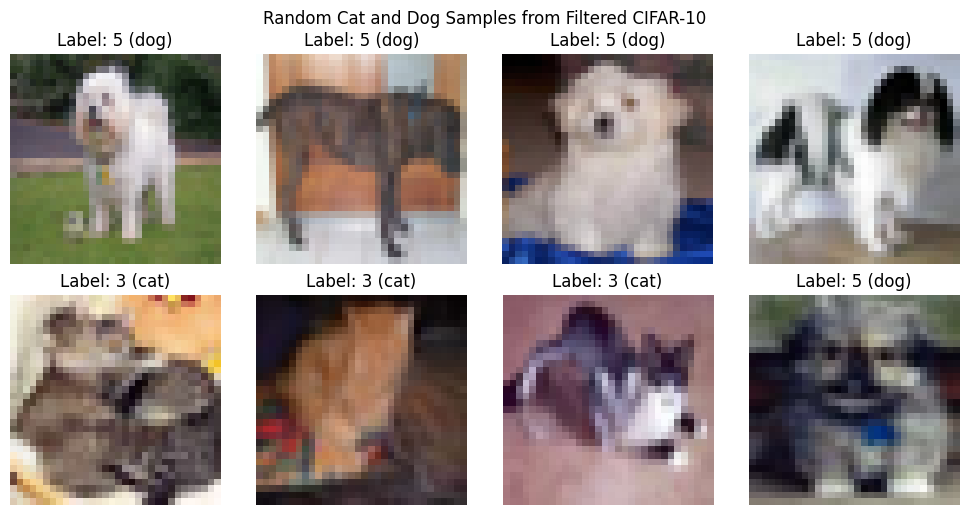

In [20]:
# Select a few random indices
num_samples_to_show = 8
indices = np.random.choice(len(filtered_dataset['train']), num_samples_to_show, replace=False)

# Create a plot
fig, axes = plt.subplots(2, 4, figsize=(10, 5)) # 2 rows, 4 columns
axes = axes.ravel() # Flatten the axes array for easy iteration

for i, idx in enumerate(indices):
    # Get the image and label from the filtered training set
    example = filtered_dataset['train'][int(idx)] # Ensure idx is int
    image = example['img']
    label = example['label']
    class_name = target_class_names[label]

    # Display the image
    axes[i].imshow(image)
    axes[i].set_title(f"Label: {label} ({class_name})")
    axes[i].axis('off') # Hide axes ticks

plt.tight_layout()
plt.suptitle("Random Cat and Dog Samples from Filtered CIFAR-10", y=1.02)
plt.show()

In [23]:
ROTATION_DEGREES = 10 # Rotate by +/- 10 degrees
COLOR_JITTER_FACTOR = 0.2 # Jitter brightness, contrast, saturation by +/- 20%
HUE_JITTER_FACTOR = 0.1 # Jitter hue by +/- 10%

# Normalization parameters for [-1, 1] range
# From [0, 1] range (after ToTensor), formula: (pixel - mean) / std
# To map 0 -> -1: (0 - 0.5) / 0.5 = -1
# To map 1 ->  1: (1 - 0.5) / 0.5 =  1
norm_mean = (0.5, 0.5, 0.5)
norm_std = (0.5, 0.5, 0.5)

In [24]:
# Transformations for the TRAINING set (including augmentations)
train_transforms = transforms.Compose([
    # Augmentations are typically applied *before* ToTensor if they operate on PIL Images
    # However, ToTensor converts to float [0,1] first, which most subsequent transforms expect.
    transforms.ToTensor(),             # Convert PIL Image (H,W,C) [0,255] to Tensor (C,H,W) [0,1]
    transforms.RandomHorizontalFlip(p=0.5), # Randomly flip horizontally
    transforms.ColorJitter(
        brightness=COLOR_JITTER_FACTOR,
        contrast=COLOR_JITTER_FACTOR,
        saturation=COLOR_JITTER_FACTOR,
        hue=HUE_JITTER_FACTOR
    ),                                 # Apply slight color jitter
    transforms.RandomRotation(degrees=ROTATION_DEGREES), # Apply slight rotation
    transforms.Normalize(mean=norm_mean, std=norm_std) # Normalize to [-1, 1]
])

In [25]:
test_transforms = transforms.Compose([
    transforms.ToTensor(),             # Convert PIL Image to Tensor (scales to [0, 1])
    transforms.Normalize(mean=norm_mean, std=norm_std) # Normalize to [-1, 1]
])

In [26]:
# Use set_transform to apply the transformations on the fly
# This function takes a batch and applies the transform to each image in the 'img' list
def apply_train_transforms(batch):
    batch['img'] = [train_transforms(image.convert("RGB")) for image in batch['img']]
    return batch

def apply_test_transforms(batch):
    batch['img'] = [test_transforms(image.convert("RGB")) for image in batch['img']]
    return batch

In [27]:
filtered_dataset['train'].set_transform(apply_train_transforms)
filtered_dataset['test'].set_transform(apply_test_transforms)

In [29]:
batch_size = 64 # Adjust as needed based on memory
num_workers = 2   # Adjust based on your system's cores

# Collate function to handle the dictionary format from datasets -> PyTorch tensors
def collate_fn(batch):
    # batch is a list of dicts like {'img': tensor, 'label': int}
    images = torch.stack([
        item['img']
        for item in batch
    ])
    labels = torch.tensor([
        item['label']
        for item in batch
    ])
    # Return images and labels directly, or a dictionary if preferred
    # return {'img': images, 'label': labels}
    return images, labels # Common format for training loops

In [30]:
train_loader = DataLoader(
    filtered_dataset['train'],
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True, # Speeds up host-to-GPU transfer if using CUDA
    collate_fn=collate_fn # Use custom collate function
)

test_loader = DataLoader(
    filtered_dataset['test'],
    batch_size=batch_size,
    shuffle=False, # No shuffling for test set
    num_workers=num_workers,
    pin_memory=True,
    collate_fn=collate_fn # Use custom collate function
)

In [31]:
def denormalize(tensor):
    # tensor = tensor * std + mean
    return tensor * torch.tensor(norm_std).view(3, 1, 1) + torch.tensor(norm_mean).view(3, 1, 1)

Batch shape: torch.Size([64, 3, 32, 32])
Labels shape: torch.Size([64])
Image tensor data type: torch.float32
Image tensor min value: -1.0000
Image tensor max value: 1.0000


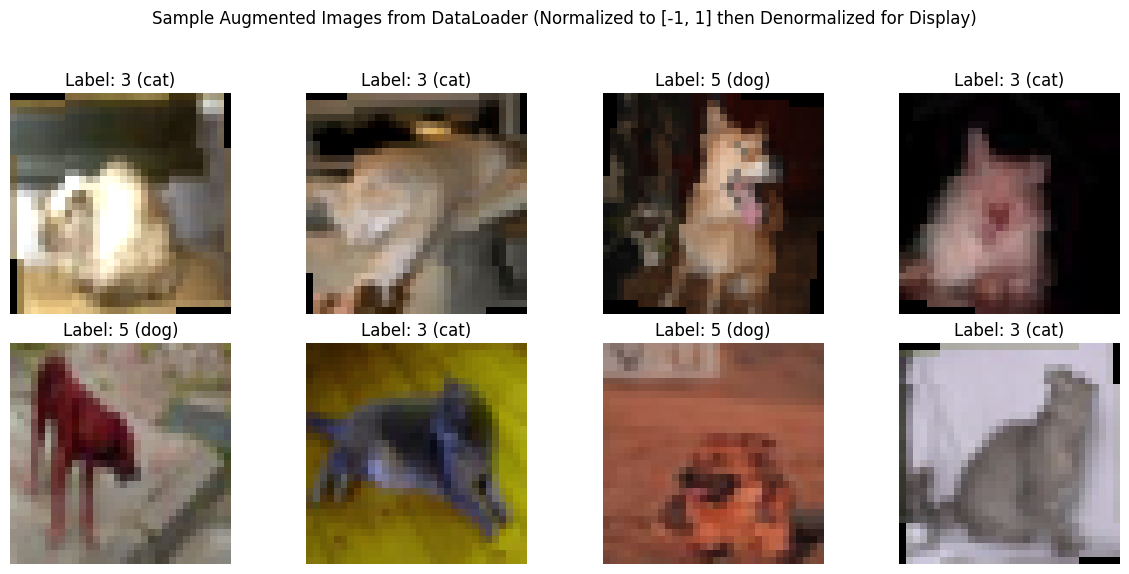


Preprocessing and DataLoader setup complete.


In [32]:
try:
    images, labels = next(iter(train_loader))

    print(f"Batch shape: {images.shape}") # Should be [batch_size, 3, 32, 32]
    print(f"Labels shape: {labels.shape}") # Should be [batch_size]
    print(f"Image tensor data type: {images.dtype}") # Should be torch.float32
    print(f"Image tensor min value: {images.min():.4f}") # Should be close to -1
    print(f"Image tensor max value: {images.max():.4f}") # Should be close to +1

    # Visualize a few images from the batch
    num_images_to_show = 8
    plt.figure(figsize=(12, 6))
    plt.suptitle("Sample Augmented Images from DataLoader (Normalized to [-1, 1] then Denormalized for Display)")
    for i in range(num_images_to_show):
        if i >= images.shape[0]: break # Don't exceed batch size
        ax = plt.subplot(2, 4, i + 1)

        img_tensor = images[i]
        img_denorm = denormalize(img_tensor) # Denormalize back to [0, 1]
        img_np = img_denorm.numpy() # Convert to numpy
        img_np = np.transpose(img_np, (1, 2, 0)) # Transpose from (C, H, W) to (H, W, C)
        img_np = np.clip(img_np, 0, 1) # Clip values just in case they went slightly out of bounds

        label = labels[i].item()
        class_name = 'cat' if label == 3 else 'dog' # Assuming cat=3, dog=5

        plt.imshow(img_np)
        plt.title(f"Label: {label} ({class_name})")
        plt.axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

except Exception as e:
    print(f"\nError during verification: {e}")
    print("This might happen if DataLoader setup failed or dependencies are missing.")

print("\nPreprocessing and DataLoader setup complete.")

In [33]:
latent_dim = 128 # Dimensionality of the latent space
img_shape = (3, 32, 32) # Input image shape (Channels, Height, Width)
channels = img_shape[0]

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [37]:
class VAE(nn.Module):
    """
    A Variational Autoencoder for 32x32 images.
    Encodes images to a latent distribution (mu, logvar) and decodes samples back to images.
    Uses Tanh activation in the final decoder layer for [-1, 1] output.
    """
    def __init__(self, latent_dim=latent_dim, img_channels=channels):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.img_channels = img_channels

        hidden_dims_enc = [32, 64, 128, 256] # Reasonably deep encoder
        hidden_dims_dec = hidden_dims_enc[::-1] # Mirror for decoder

        # --- Encoder ---
        modules_enc = [] # Use a different name to avoid conflict
        in_channels_enc = self.img_channels # Use a different name
        for h_dim in hidden_dims_enc:
            modules_enc.append(
                nn.Sequential(
                    nn.Conv2d(in_channels_enc, out_channels=h_dim,
                              kernel_size=3, stride=2, padding=1), # Downsample H/W by 2
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU(0.2, inplace=True)
                )
            )
            in_channels_enc = h_dim
        self.encoder_conv = nn.Sequential(*modules_enc) # Output: hidden_dims_enc[-1] x 2 x 2

        # Calculate flattened size dynamically (assuming 32x32 input -> 2x2 after 4 strides of 2)
        # ---- CORRECTED LINE ----
        self.final_enc_H = 32 // (2**len(hidden_dims_enc)) # 32 / 2^4 = 2
        # ---- CORRECTED USAGE ----
        self.flattened_size = hidden_dims_enc[-1] * self.final_enc_H**2

        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_size, latent_dim)

        # --- Decoder ---
        self.decoder_input = nn.Linear(latent_dim, self.flattened_size)

        modules_dec = [] # Use a different name
        in_channels_dec = hidden_dims_dec[0] # Start with the deepest channel dim
        for i in range(len(hidden_dims_dec) - 1):
            modules_dec.append(
                nn.Sequential(
                    nn.ConvTranspose2d(in_channels_dec, hidden_dims_dec[i+1],
                                       kernel_size=4, stride=2, padding=1), # Upsample H/W by 2
                    nn.BatchNorm2d(hidden_dims_dec[i+1]),
                    nn.LeakyReLU(0.2, inplace=True)
                )
            )
            in_channels_dec = hidden_dims_dec[i+1]

        # Final layer to restore image channels and size, with Tanh activation
        modules_dec.append(
            nn.Sequential(
                nn.ConvTranspose2d(hidden_dims_dec[-1], self.img_channels,
                                   kernel_size=4, stride=2, padding=1),
                nn.Tanh() # Output range [-1, 1]
            )
        )
        self.decoder_conv = nn.Sequential(*modules_dec) # Output: img_channels x 32 x 32

    def encode(self, img):
        """Encodes an image into latent distribution parameters."""
        result = self.encoder_conv(img)
        result = torch.flatten(result, start_dim=1)
        mu = self.fc_mu(result)
        logvar = self.fc_logvar(result)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """Reparameterization trick to sample from N(mu, var)."""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std) # Sample epsilon from N(0, 1)
        return mu + eps * std

    def decode(self, z):
        """Decodes a latent vector z into an image."""
        result = self.decoder_input(z)
        # Reshape to match the shape before flattening in the encoder
        # ---- CORRECTED USAGE ----
        # Need the number of output channels from the last encoder conv layer
        last_enc_channels = self.encoder_conv[-1][0].out_channels
        result = result.view(-1, last_enc_channels, self.final_enc_H, self.final_enc_H)
        img = self.decoder_conv(result)
        return img

    def forward(self, img):
        """Full forward pass: encode -> reparameterize -> decode."""
        mu, logvar = self.encode(img)
        z = self.reparameterize(mu, logvar)
        reconstructed_img = self.decode(z)
        return reconstructed_img, mu, logvar

In [38]:
class Generator(nn.Module):
    """
    DCGAN-style Generator for 32x32 images.
    Takes a latent vector z and maps it to an image.
    Uses Tanh activation in the final layer for [-1, 1] output.
    """
    def __init__(self, latent_dim=latent_dim, img_channels=channels):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.img_channels = img_channels
        self.init_size = 4 # Start with 4x4 feature maps

        # Project latent vector and reshape
        self.l1 = nn.Sequential(
            nn.Linear(latent_dim, 256 * self.init_size**2), # More capacity
            nn.BatchNorm1d(256 * self.init_size**2), # Use BatchNorm1d after linear
            nn.LeakyReLU(0.2, inplace=True)
            )

        # Upsampling convolutional layers
        self.conv_blocks = nn.Sequential(
            # Input: 256 x 4 x 4
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # -> 128 x 8 x 8
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), # -> 64 x 16 x 16
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(64, self.img_channels, kernel_size=4, stride=2, padding=1), # -> channels x 32 x 32
            nn.Tanh() # Final activation for [-1, 1] output
        )

    def forward(self, z):
        # Project and reshape
        out = self.l1(z)
        out = out.view(out.shape[0], 256, self.init_size, self.init_size)
        # Upsample
        img = self.conv_blocks(out)
        return img

In [39]:
class MinibatchDiscrimination(nn.Module):
    """
    Minibatch Discrimination Layer for GANs.
    Calculates similarity between samples in a batch and concatenates
    these features to the original input features. Helps prevent mode collapse.
    """
    def __init__(self, in_features, out_features, intermediate_features=64):
        """
        Args:
            in_features: Number of input features (e.g., flattened size from conv layers).
            out_features: Number of output features for the similarity matrix per sample.
            intermediate_features: Number of intermediate features in the transformation matrix T.
        """
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.intermediate_features = intermediate_features

        # Transformation matrix T: in_features -> out_features * intermediate_features
        self.T = nn.Parameter(torch.Tensor(in_features, out_features * intermediate_features))
        nn.init.normal_(self.T, 0, 1) # Initialize T with N(0,1)

    def forward(self, x):
        # x shape: (batch_size, in_features)

        # Calculate Matrix M = x * T
        # M shape: (batch_size, out_features * intermediate_features)
        M = x.mm(self.T)

        # Reshape M to (batch_size, out_features, intermediate_features)
        M = M.view(-1, self.out_features, self.intermediate_features)

        # Calculate L1 distance between samples (similarity)
        # Expand M for broadcasting: (batch_size, 1, out_features, intermediate_features)
        #                            (1, batch_size, out_features, intermediate_features)
        M_expanded_1 = M.unsqueeze(1)
        M_expanded_2 = M.unsqueeze(0)

        # L1 distance: |M_i - M_j|
        # Shape: (batch_size, batch_size, out_features, intermediate_features)
        l1_dist = torch.abs(M_expanded_1 - M_expanded_2)

        # Sum over intermediate features: sum(|M_i - M_j|)
        # Shape: (batch_size, batch_size, out_features)
        c_ij = torch.sum(l1_dist, dim=3)

        # Apply negative exponential: exp(-sum(|M_i - M_j|))
        # This makes similar samples have values close to 1, dissimilar ones close to 0
        # Shape: (batch_size, batch_size, out_features)
        o_ij = torch.exp(-c_ij)

        # Sum over all other samples j (excluding self, i=j): sum_{j!=i} exp(-sum(|M_i - M_j|))
        # We sum over dim=1 (the j dimension)
        # Shape: (batch_size, out_features)
        o_i = torch.sum(o_ij, dim=1)

        # Subtract the self-similarity exp(0)=1 implicitly contained in the sum
        # Alternatively, one could zero out the diagonal before summing. Summing and subtracting 1 is common.
        # However, if we compute o_i = sum(o_ij, dim=1), the diagonal o_ii = exp(-sum(|M_i - M_i|)) = exp(0) = 1
        # So, we might not need to subtract 1 if T is initialized well. Let's proceed without subtraction first.
        # A simpler approach: just sum everything, including the diagonal.
        o_i = torch.sum(o_ij, dim=1)

        # Concatenate o_i with the original input x
        # x shape: (batch_size, in_features)
        # o_i shape: (batch_size, out_features)
        x_combined = torch.cat([x, o_i], dim=1)
        # Output shape: (batch_size, in_features + out_features)

        return x_combined

In [40]:
class Discriminator(nn.Module):
    """
    Custom Discriminator for GAN, designed as a similarity network.
    Takes two images (real and fake) and outputs a dissimilarity score.
    Higher score means *more dissimilar*.
    Includes Minibatch Discrimination.
    """
    def __init__(self, img_channels=channels, use_minibatch_discrimination=True):
        super(Discriminator, self).__init__()
        self.use_minibatch_discrimination = use_minibatch_discrimination

        # --- Base Feature Extractor Network ---
        # Shared network applied to both input images
        hidden_dims = [64, 128, 256] # Similar complexity to VAE encoder
        modules = []
        in_channels = img_channels
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, h_dim, kernel_size=4, stride=2, padding=1), # Downsample
                    # Using LayerNorm might be more stable here than BatchNorm
                    # nn.LayerNorm([h_dim, H_out, W_out]) # Need to calculate H_out, W_out or apply later
                    nn.BatchNorm2d(h_dim), # Let's try BatchNorm first
                    nn.LeakyReLU(0.2, inplace=True),
                    nn.Dropout2d(0.25) # Add dropout for regularization
                )
            )
            in_channels = h_dim
        self.base_network_conv = nn.Sequential(*modules) # Output: 256 x 4 x 4

        # Calculate flattened size after convolutions
        self.final_H = 32 // (2**len(hidden_dims)) # 32 / 2^3 = 4
        self.flattened_size = hidden_dims[-1] * self.final_H**2 # 256 * 4 * 4 = 4096

        # Optional: Fully connected layer after convolutions in base network
        self.base_network_fc_dim = 1024
        self.base_network_fc = nn.Sequential(
            nn.Linear(self.flattened_size, self.base_network_fc_dim),
            nn.LeakyReLU(0.2, inplace=True)
            # No Batch/LayerNorm here? Maybe. Let's omit for now.
        )
        current_feature_dim = self.base_network_fc_dim

        # --- Minibatch Discrimination ---
        if self.use_minibatch_discrimination:
            self.minibatch_layer = MinibatchDiscrimination(
                in_features=current_feature_dim,
                out_features=128, # Number of similarity features per sample
                intermediate_features=32 # Intermediate dim for T matrix
            )
            # The output dimension will increase after minibatch layer
            current_feature_dim += 128 # Add the minibatch features dimension

        # --- Final Comparison MLP ---
        # Takes the output features (potentially including minibatch features)
        # from *both* images, compares them, and outputs a single dissimilarity score.
        # We will compute features for img1 and img2, then compute difference, then MLP.
        self.comparison_mlp = nn.Sequential(
            nn.Linear(current_feature_dim, 512), # Input is the dimension of features after potential minibatch
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3), # Dropout in the comparison layers
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1) # Single output neuron for the dissimilarity score
            # No final activation - raw score (logit) is often used with BCEWithLogitsLoss or hinge loss etc.
            # A higher score will mean "more dissimilar".
        )

    def extract_features(self, img):
        """Applies the base convolutional and FC network + Minibatch Discrimination."""
        features = self.base_network_conv(img)
        features = torch.flatten(features, start_dim=1)
        features = self.base_network_fc(features)

        if self.use_minibatch_discrimination:
             # Minibatch layer expects (batch, features)
             features = self.minibatch_layer(features)
        return features


    def forward(self, img1, img2):
        """
        Calculates a dissimilarity score between img1 and img2.

        Args:
            img1: First batch of images (e.g., real images).
            img2: Second batch of images (e.g., fake images).

        Returns:
            A tensor of shape (batch_size, 1) representing the dissimilarity score.
            Higher score means img1 and img2 are considered more dissimilar by the network.
        """
        # Extract features for both images using the shared base network + minibatch
        features1 = self.extract_features(img1)
        features2 = self.extract_features(img2)

        # Calculate element-wise absolute difference between features
        # This captures the magnitude of difference in the learned feature space.
        feature_diff = torch.abs(features1 - features2)

        # Pass the difference through the final MLP to get the dissimilarity score
        dissimilarity_score = self.comparison_mlp(feature_diff)

        return dissimilarity_score

In [41]:
vae = VAE(latent_dim=latent_dim, img_channels=channels).to(device)
generator = Generator(latent_dim=latent_dim, img_channels=channels).to(device)
discriminator = Discriminator(img_channels=channels, use_minibatch_discrimination=True).to(device)

In [42]:
print("--- VAE Architecture ---")
print(vae)
print("\n--- Generator Architecture ---")
print(generator)
print("\n--- Discriminator Architecture ---")
print(discriminator)

# Test forward pass (optional, requires dummy data)
def test_models():
    print("\n--- Testing Forward Passes (Dummy Data) ---")
    # Create dummy data on the correct device
    dummy_z = torch.randn(batch_size, latent_dim).to(device)
    dummy_img_batch = torch.randn(batch_size, channels, 32, 32).to(device)

    # Test Generator
    try:
        gen_output = generator(dummy_z)
        print(f"Generator Output Shape: {gen_output.shape}") # Expect: [batch_size, 3, 32, 32]
        print(f"Generator Output Range: [{gen_output.min():.2f}, {gen_output.max():.2f}]") # Expect: [-1, 1]
    except Exception as e:
        print(f"Error testing Generator: {e}")

    # Test VAE
    try:
        vae_recon, vae_mu, vae_logvar = vae(dummy_img_batch)
        print(f"VAE Reconstruction Shape: {vae_recon.shape}") # Expect: [batch_size, 3, 32, 32]
        print(f"VAE Mu Shape: {vae_mu.shape}") # Expect: [batch_size, latent_dim]
        print(f"VAE LogVar Shape: {vae_logvar.shape}") # Expect: [batch_size, latent_dim]
        print(f"VAE Output Range: [{vae_recon.min():.2f}, {vae_recon.max():.2f}]") # Expect: [-1, 1]
    except Exception as e:
        print(f"Error testing VAE: {e}")

    # Test Discriminator
    try:
        # Need two batches of images for the similarity discriminator
        dummy_img_batch2 = torch.randn(batch_size, channels, 32, 32).to(device)
        disc_output = discriminator(dummy_img_batch, dummy_img_batch2)
        print(f"Discriminator Output Shape: {disc_output.shape}") # Expect: [batch_size, 1]
    except Exception as e:
        print(f"Error testing Discriminator: {e}")

# Run the test if desired (make sure batch_size is defined from dataloader section)
if 'batch_size' in locals() and batch_size > 1: # Minibatch requires batch_size > 1
   test_models()
else:
   print("\nSkipping forward pass test: 'batch_size' not defined or <= 1.")

print("\nModel architectures defined and initialized.")

--- VAE Architecture ---
VAE(
  (encoder_conv): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [ ]:
# --- Configuration & Hyperparameters ---
epochs_vae = 50        # Total VAE training epochs
epochs_gan = 100       # Total GAN training epochs (GANs often need more)
lr_vae = 1e-3          # Learning rate for VAE
lr_g = 2e-4            # Learning rate for Generator
lr_d = 2e-4            # Learning rate for Discriminator
beta1 = 0.5            # Adam optimizer beta1 (common for GANs)
beta2 = 0.999          # Adam optimizer beta2
beta_vae = 1.0         # Weight for KL divergence loss in VAE (can be tuned)
sample_interval = 5    # Epoch interval to save generated samples
checkpoint_interval = 10 # Epoch interval to save model checkpoints
results_dir = "training_results"
vae_samples_dir = os.path.join(results_dir, "vae_samples")
gan_samples_dir = os.path.join(results_dir, "gan_samples")
checkpoints_dir = os.path.join(results_dir, "checkpoints")


In [ ]:
# Create directories if they don't exist
os.makedirs(vae_samples_dir, exist_ok=True)
os.makedirs(gan_samples_dir, exist_ok=True)
os.makedirs(checkpoints_dir, exist_ok=True)

# --- Optimizers ---
vae_optimizer = optim.Adam(vae.parameters(), lr=lr_vae)
g_optimizer = optim.Adam(generator.parameters(), lr=lr_g, betas=(beta1, beta2))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(beta1, beta2))

In [ ]:
# --- Loss Functions ---
def vae_loss_function(recon_x, x, mu, logvar, beta=beta_vae):
    """Calculates VAE loss = Reconstruction Loss + Beta * KL Divergence."""
    # Use MSE loss for reconstruction since images are [-1, 1]
    recon_loss = F.mse_loss(recon_x, x, reduction='sum') / x.size(0) # Average over batch

    # KL divergence: 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # Formula derived for N(mu, var) vs N(0, 1)
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0) # Average over batch

    total_loss = recon_loss + beta * kl_div
    return total_loss, recon_loss, kl_div

In [ ]:
# GAN loss is handled directly in the training loop based on discriminator scores


In [ ]:
def save_sample_images(epoch, images, output_dir, model_name, num_images=64):
    """Saves a grid of generated images."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Take subset if needed, make grid, denormalize, save
    grid = make_grid(images[:num_images], nrow=8, normalize=False) # Already in [-1, 1]
    grid_denorm = denormalize(grid) # Denormalize to [0, 1] for saving/viewing
    save_path = os.path.join(output_dir, f"{model_name}_epoch_{epoch:03d}.png")
    save_image(grid_denorm, save_path)
    print(f"Saved sample images to {save_path}")

In [ ]:
# --- VAE Training Function ---
def train_vae(model, data_loader, optimizer, loss_fn, epochs, device, sample_interval, save_dir, checkpoint_dir):
    print("\n--- Starting VAE Training ---")
    model.train() # Set model to training mode
    fixed_noise = torch.randn(64, latent_dim, device=device) # For consistent sample generation
    history = {'epoch': [], 'total_loss': [], 'recon_loss': [], 'kl_loss': []}

    for epoch in range(epochs):
        epoch_start_time = time.time()
        total_loss_epoch = 0.0
        recon_loss_epoch = 0.0
        kl_loss_epoch = 0.0
        num_batches = 0

        for i, (real_imgs, _) in enumerate(data_loader):
            real_imgs = real_imgs.to(device)

            # Forward pass
            recon_imgs, mu, logvar = model(real_imgs)

            # Calculate loss
            loss, recon, kl = loss_fn(recon_imgs, real_imgs, mu, logvar)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate losses for epoch average
            total_loss_epoch += loss.item()
            recon_loss_epoch += recon.item()
            kl_loss_epoch += kl.item()
            num_batches += 1

            # Print progress
            if (i + 1) % 100 == 0 or (i + 1) == len(data_loader):
                 print(f"[VAE Epoch {epoch+1}/{epochs}] [Batch {i+1}/{len(data_loader)}] "
                       f"[Total Loss: {loss.item():.4f}] [Recon Loss: {recon.item():.4f}] [KL Loss: {kl.item():.4f}]")

        # Calculate average losses for the epoch
        avg_total_loss = total_loss_epoch / num_batches
        avg_recon_loss = recon_loss_epoch / num_batches
        avg_kl_loss = kl_loss_epoch / num_batches
        epoch_time = time.time() - epoch_start_time

        # Log history
        history['epoch'].append(epoch + 1)
        history['total_loss'].append(avg_total_loss)
        history['recon_loss'].append(avg_recon_loss)
        history['kl_loss'].append(avg_kl_loss)

        print(f"--- VAE Epoch {epoch+1} Summary ---")
        print(f"Time: {epoch_time:.2f}s")
        print(f"Avg Total Loss: {avg_total_loss:.4f}")
        print(f"Avg Recon Loss: {avg_recon_loss:.4f}")
        print(f"Avg KL Loss:    {avg_kl_loss:.4f}")
        print("-----------------------------")

        # Generate and save samples
        if (epoch + 1) % sample_interval == 0 or epoch == epochs - 1:
            model.eval() # Set model to evaluation mode
            with torch.no_grad():
                generated_samples = model.decode(fixed_noise)
            save_sample_images(epoch + 1, generated_samples.cpu(), save_dir, "vae")
            model.train() # Set back to training mode

        # Save checkpoint
        if (epoch + 1) % checkpoint_interval == 0 or epoch == epochs - 1:
            checkpoint_path = os.path.join(checkpoint_dir, f"vae_epoch_{epoch+1}.pth")
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_total_loss,
            }, checkpoint_path)
            print(f"Saved VAE checkpoint to {checkpoint_path}")

    print("--- VAE Training Finished ---")
    return history


In [ ]:
def train_gan(generator, discriminator, data_loader, g_optimizer, d_optimizer, epochs, device, latent_dim, sample_interval, save_dir, checkpoint_dir):
    print("\n--- Starting GAN Training ---")
    generator.train()
    discriminator.train()
    fixed_noise = torch.randn(64, latent_dim, device=device) # For consistent sample generation
    history = {'epoch': [], 'g_loss': [], 'd_loss': [], 'avg_dissimilarity': []}

    for epoch in range(epochs):
        epoch_start_time = time.time()
        g_loss_epoch = 0.0
        d_loss_epoch = 0.0
        dissimilarity_epoch = 0.0
        num_batches = 0

        for i, (real_imgs, _) in enumerate(data_loader):
            batch_size = real_imgs.size(0)
            real_imgs = real_imgs.to(device)

            # --- Train Discriminator ---
            # Goal: Maximize dissimilarity D(real, fake) -> Minimize -D(real, fake)
            d_optimizer.zero_grad()

            # Generate fake images
            z = torch.randn(batch_size, latent_dim, device=device)
            fake_imgs = generator(z).detach() # Detach generator output

            # Calculate dissimilarity score for real vs fake
            dissimilarity_score_d = discriminator(real_imgs, fake_imgs)

            # Discriminator loss: We want to maximize the score, so minimize its negative
            d_loss = -torch.mean(dissimilarity_score_d)

            d_loss.backward()
            d_optimizer.step()

            # --- Train Generator ---
            # Goal: Minimize dissimilarity D(real, fake) -> Minimize D(real, fake)
            g_optimizer.zero_grad()

            # Generate new fake images (without detaching)
            z = torch.randn(batch_size, latent_dim, device=device)
            fake_imgs_g = generator(z)

            # Calculate dissimilarity score for real vs NEW fake
            # We need real_imgs again as the discriminator takes pairs
            dissimilarity_score_g = discriminator(real_imgs, fake_imgs_g)

            # Generator loss: We want to minimize the score
            g_loss = torch.mean(dissimilarity_score_g)

            g_loss.backward()
            g_optimizer.step()

            # Accumulate losses and scores for epoch average
            g_loss_epoch += g_loss.item()
            d_loss_epoch += d_loss.item()
            # We can track the dissimilarity score the Generator achieved this step
            dissimilarity_epoch += torch.mean(dissimilarity_score_g).item()
            num_batches += 1

             # Print progress
            if (i + 1) % 100 == 0 or (i + 1) == len(data_loader):
                 print(f"[GAN Epoch {epoch+1}/{epochs}] [Batch {i+1}/{len(data_loader)}] "
                       f"[D Loss: {d_loss.item():.4f}] [G Loss: {g_loss.item():.4f}] "
                       f"[Avg Dissim Score (G): {torch.mean(dissimilarity_score_g).item():.4f}]")

        # Calculate average losses/scores for the epoch
        avg_g_loss = g_loss_epoch / num_batches
        avg_d_loss = d_loss_epoch / num_batches
        avg_dissimilarity = dissimilarity_epoch / num_batches
        epoch_time = time.time() - epoch_start_time

        # Log history
        history['epoch'].append(epoch + 1)
        history['g_loss'].append(avg_g_loss)
        history['d_loss'].append(avg_d_loss)
        history['avg_dissimilarity'].append(avg_dissimilarity)

        print(f"--- GAN Epoch {epoch+1} Summary ---")
        print(f"Time: {epoch_time:.2f}s")
        print(f"Avg G Loss: {avg_g_loss:.4f}")
        print(f"Avg D Loss: {avg_d_loss:.4f}") # Note: D loss minimizes negative score
        print(f"Avg Dissim Score (G): {avg_dissimilarity:.4f}") # Avg score G achieved
        print("-----------------------------")

        # Generate and save samples
        if (epoch + 1) % sample_interval == 0 or epoch == epochs - 1:
            generator.eval() # Set generator to evaluation mode
            with torch.no_grad():
                generated_samples = generator(fixed_noise)
            save_sample_images(epoch + 1, generated_samples.cpu(), save_dir, "gan")
            generator.train() # Set back to training mode

        # Save checkpoint
        if (epoch + 1) % checkpoint_interval == 0 or epoch == epochs - 1:
            checkpoint_path_g = os.path.join(checkpoint_dir, f"gan_generator_epoch_{epoch+1}.pth")
            checkpoint_path_d = os.path.join(checkpoint_dir, f"gan_discriminator_epoch_{epoch+1}.pth")
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': generator.state_dict(),
                'optimizer_state_dict': g_optimizer.state_dict(),
                'loss': avg_g_loss,
            }, checkpoint_path_g)
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': discriminator.state_dict(),
                'optimizer_state_dict': d_optimizer.state_dict(),
                'loss': avg_d_loss,
             }, checkpoint_path_d)
            print(f"Saved GAN checkpoints to {checkpoint_path_g} and {checkpoint_path_d}")

    print("--- GAN Training Finished ---")
    return history


--- Starting VAE Training ---
[VAE Epoch 1/50] [Batch 100/157] [Total Loss: 407.6060] [Recon Loss: 362.1572] [KL Loss: 45.4487]
[VAE Epoch 1/50] [Batch 157/157] [Total Loss: 363.2449] [Recon Loss: 311.9138] [KL Loss: 51.3311]
--- VAE Epoch 1 Summary ---
Time: 20.21s
Avg Total Loss: 505.0935
Avg Recon Loss: 463.3934
Avg KL Loss:    41.7001
-----------------------------
[VAE Epoch 2/50] [Batch 100/157] [Total Loss: 353.4170] [Recon Loss: 302.9450] [KL Loss: 50.4720]
[VAE Epoch 2/50] [Batch 157/157] [Total Loss: 295.6181] [Recon Loss: 246.1504] [KL Loss: 49.4677]
--- VAE Epoch 2 Summary ---
Time: 18.86s
Avg Total Loss: 340.9683
Avg Recon Loss: 291.4843
Avg KL Loss:    49.4839
-----------------------------
[VAE Epoch 3/50] [Batch 100/157] [Total Loss: 304.1175] [Recon Loss: 251.9978] [KL Loss: 52.1196]
[VAE Epoch 3/50] [Batch 157/157] [Total Loss: 261.4548] [Recon Loss: 208.0620] [KL Loss: 53.3928]
--- VAE Epoch 3 Summary ---
Time: 20.63s
Avg Total Loss: 289.5129
Avg Recon Loss: 238.3628


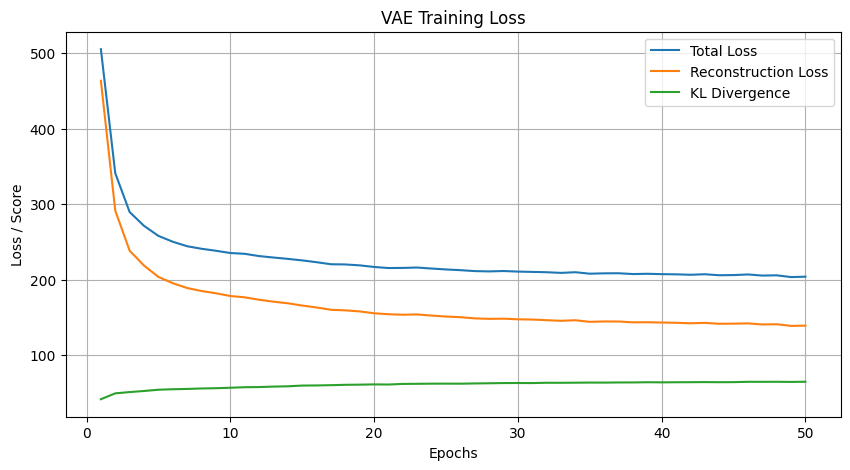

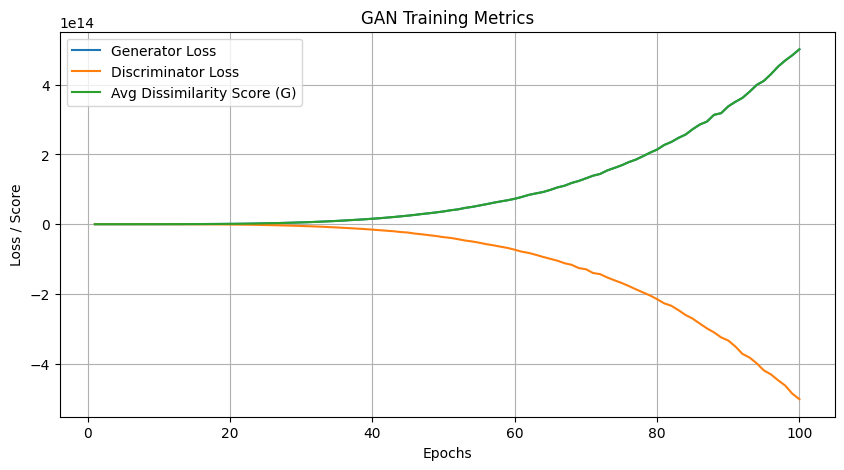

In [ ]:
# Train VAE
vae_history = train_vae(vae, train_loader, vae_optimizer, vae_loss_function, epochs_vae, device, sample_interval, vae_samples_dir, checkpoints_dir)

# Train GAN
gan_history = train_gan(generator, discriminator, train_loader, g_optimizer, d_optimizer, epochs_gan, device, latent_dim, sample_interval, gan_samples_dir, checkpoints_dir)

print("\n--- All Training Complete ---")

# --- Plot Training Curves (Example) ---
def plot_history(history, title, loss_keys, loss_labels):
    plt.figure(figsize=(10, 5))
    for key, label in zip(loss_keys, loss_labels):
        if key in history:
            plt.plot(history['epoch'], history[key], label=label)
    plt.xlabel("Epochs")
    plt.ylabel("Loss / Score")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(results_dir, f"{title.lower().replace(' ', '_')}_curve.png"))
    plt.show()

# Plot VAE losses
plot_history(vae_history, "VAE Training Loss",
             ['total_loss', 'recon_loss', 'kl_loss'],
             ['Total Loss', 'Reconstruction Loss', 'KL Divergence'])

# Plot GAN losses and dissimilarity score
plot_history(gan_history, "GAN Training Metrics",
             ['g_loss', 'd_loss', 'avg_dissimilarity'],
             ['Generator Loss', 'Discriminator Loss', 'Avg Dissimilarity Score (G)'])

In [44]:
from google.colab import files

files.download('/content/training_results') # Assuming training_results is in /content/

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>